We need to pip install scikit-plot

In [ ]:
pip install scikit-plot


Import the required moduels 

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
import cv2                 
import numpy as np         
from random import shuffle
import matplotlib.pyplot as plt
import glob as gb
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import PIL
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from google.colab import drive

In [ ]:

drive.mount('/gdrive')


In [4]:
#paths to the train and test folders
TrainImage = r'/gdrive/MyDrive/Data/train'
TestImage = r'/gdrive/MyDrive/Data/test'

We need to convert the classes to numbers so they can be converted to a binary class matrix

In [5]:


def getCode(label):
  '''
  Takes in Class and returns the Associated number.

  Parameters:
    string: either 'NORMAL','PNEUMONIA' or 'COVID19'
  
  Returns:
    Int- 0, 1 or 2 if 'NORMAL','PNEUMONIA' or 'COVID19' respectively
  '''
  
  Labels= {'NORMAL':0,'PNEUMONIA':1,'COVID19':2}
  
  return Labels[label]


       
        


write a function to convert all images in a folder to an array splitting them into features (X) and label (y)

In [6]:
def getData(dir,resizeImage):
  '''
  Iterates through given directory resizes the image and converts features to array
  and class to catagorical array.

  Parameters:
    dir: the file path of the chosen directory
    resizeImage: the sixe you wish to resize the image to 
    e.g. resizeImage=64 would resize image to 64x64 
  Returns:
    X: array- each row is the features of an image in the given directory
    y: array- each ith row is the class of the features in the ith =row of X
              converted to a binary class matrix.
  '''
  #create empty lists to append the arrays
  X=[]
  y=[]
  #itterate through the folders in the chosen directory
  for folder in  os.listdir(dir) :  
      #select all the files in that folder
      files = gb.glob(pathname= str( dir  +"/" +folder+ '//*.jpg' )) 
      for file in files:
              #for each image (file)
              picture=cv2.imread(file)
              #resize to the given dimension 
              imageArray=cv2.resize(picture,(resizeImage,resizeImage))
              #append features
              X.append(list(imageArray))
              #append catagory code
              y.append(getCode(folder))
  X=np.array(X)
  #convert to a binary class matrix
  y = to_categorical(y, 3)
  return X,y

In [7]:
#get train data
X_train, y_train = getData(TrainImage,64)
# get test data
X_test , y_test = getData(TestImage,64)

Test is converted

In [ ]:
test1 = X_train[0]
plt.imshow(test1, interpolation='nearest')
plt.show()
%matplotlib inline 

Then need validation data so use train_test_split to split the training data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

### ResNet50

In [ ]:
resnetModel = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnetModel.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#need to add output layer with 3 classes

resnetModel.add(Dense(3, activation='softmax'))

In [ ]:
resnetModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnetModel.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

### VGG

In [ ]:
VGG16Model = Sequential()

VG16pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',
                   weights='imagenet')
for layer in VG16pretrained_model.layers:
        layer.trainable=False


VGG16Model.add(VG16pretrained_model)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG16Model.add(Dense(3, activation='softmax'))

In [ ]:
VGG16Model.summary()
VGG16Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


pred test ResNet

In [ ]:
ResPredictionsOne = resnetModel.predict(X_test)

In [ ]:
ResPredictionsOneClass = [np.argmax(x) for x in ResPredictionsOne]

In [ ]:
y_testLabeles = [np.argmax(x) for x in y_test]

In [ ]:
resNetConfusionMatrix = multilabel_confusion_matrix(y_testLabeles, ResPredictionsOneClass)
print(resNetConfusionMatrix)

[[[ 605  366]
  [ 277   40]]

 [[  89  344]
  [ 451  404]]

 [[1040  132]
  [ 114    2]]]


In [ ]:
accuracy_score(y_testLabeles, ResPredictionsOneClass)

0.34627329192546585

In [ ]:
print(classification_report(y_testLabeles, ResPredictionsOneClass))

              precision    recall  f1-score   support

           0       0.10      0.13      0.11       317
           1       0.54      0.47      0.50       855
           2       0.01      0.02      0.02       116

    accuracy                           0.35      1288
   macro avg       0.22      0.21      0.21      1288
weighted avg       0.38      0.35      0.36      1288



pred test VGG


In [ ]:
predictionsVGG = VGG16Model.predict(X_test)

In [ ]:
predictions_doneVGG = [np.argmax(x) for x in predictionsVGG]

In [ ]:
VGGConfusionMatrix = multilabel_confusion_matrix(y_testLabeles, predictions_doneVGG)
print(resNetConfusionMatrix)

[[[ 605  366]
  [ 277   40]]

 [[  89  344]
  [ 451  404]]

 [[1040  132]
  [ 114    2]]]


In [ ]:
accuracy_score(y_testLabeles, predictions_doneVGG)

0.6343167701863354

In [ ]:
print(classification_report(y_testLabeles, predictions_doneVGG))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       317
           1       0.82      0.71      0.76       855
           2       0.14      0.27      0.19       116

    accuracy                           0.63      1288
   macro avg       0.50      0.51      0.50      1288
weighted avg       0.69      0.63      0.66      1288



We then fit Resenet50

In [ ]:
resnetModelFit = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnetModelFit.add(pretrained_model)

resnetModelFit.add(Dense(3, activation='softmax'))

In [ ]:
resnetModelFit.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)

In [ ]:
resnetModelFitHistory = resnetModelFit.fit(x=X_train,y=y_train,validation_data=(X_val,y_val), epochs=400,callbacks=[early_stop])

Epoch 1/400
122/122 [==============================] - 50s 393ms/step - loss: 0.4273 - accuracy: 0.8647 - val_loss: 0.2903 - val_accuracy: 0.9024
Epoch 2/400
122/122 [==============================] - 47s 387ms/step - loss: 0.2514 - accuracy: 0.9096 - val_loss: 0.2527 - val_accuracy: 0.9163
Epoch 3/400
122/122 [==============================] - 48s 395ms/step - loss: 0.2752 - accuracy: 0.9169 - val_loss: 0.6379 - val_accuracy: 0.8242
Epoch 4/400
122/122 [==============================] - 48s 391ms/step - loss: 0.3458 - accuracy: 0.9114 - val_loss: 0.2305 - val_accuracy: 0.9187
Epoch 5/400
122/122 [==============================] - 48s 391ms/step - loss: 0.1388 - accuracy: 0.9463 - val_loss: 0.2225 - val_accuracy: 0.9233
Epoch 6/400
122/122 [==============================] - 48s 391ms/step - loss: 0.1346 - accuracy: 0.9476 - val_loss: 0.2221 - val_accuracy: 0.9233
Epoch 7/400
122/122 [==============================] - 48s 391ms/step - loss: 0.1133 - accuracy: 0.9561 - val_loss: 0.2183 -

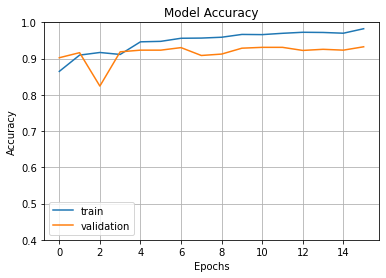

In [ ]:
fig1 = plt.gcf()
plt.plot(resnetModelFitHistory.history['accuracy'])
plt.plot(resnetModelFitHistory.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


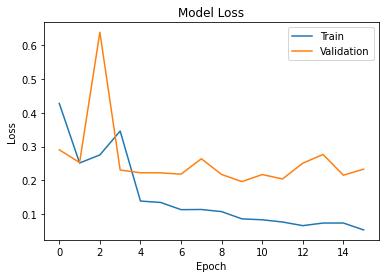

In [ ]:
plt.plot(resnetModelFitHistory.history['loss'])

plt.plot(resnetModelFitHistory.history['val_loss'])

plt.title('Model Loss')

plt.ylabel('Loss')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
resnetModelFitPredictions = resnetModelFit.predict(X_test)

In [ ]:
resnetModelFitPredictionsClass = [np.argmax(x) for x in resnetModelFitPredictions]

In [ ]:
y_testLabeles = [np.argmax(x) for x in y_test]

In [ ]:
resNetConfusionMatrix = multilabel_confusion_matrix(y_testLabeles, resnetModelFitPredictionsClass)
print(resNetConfusionMatrix)

[[[ 954   17]
  [  65  252]]

 [[ 357   76]
  [  17  838]]

 [[1169    3]
  [  14  102]]]


In [ ]:
accuracy_score(y_testLabeles, resnetModelFitPredictionsClass)

0.9254658385093167

In [ ]:
print(classification_report(y_testLabeles, resnetModelFitPredictionsClass))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       317
           1       0.92      0.98      0.95       855
           2       0.97      0.88      0.92       116

    accuracy                           0.93      1288
   macro avg       0.94      0.88      0.91      1288
weighted avg       0.93      0.93      0.92      1288



That gave us our baseline of 92%

In [ ]:
resnetFinal = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(64,64,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnetFinal.add(pretrained_model)

resnetFinal.add(Dense(1024, activation='relu'))
resnetFinal.add(Dropout(0.5))
resnetFinal.add(Dense(512, activation='relu'))
resnetFinal.add(Dropout(0.5))
resnetFinal.add(Dense(256, activation='relu'))
resnetFinal.add(Dropout(0.5))
resnetFinal.add(Dense(128, activation='relu'))
resnetFinal.add(Dropout(0.5))
resnetFinal.add(Dense(3, activation='softmax'))

In [ ]:
resnetFinal.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
resnetFinalHistory = resnetFinal.fit(x=X_train,y=y_train,validation_data=(X_val,y_val), epochs=400,callbacks=[early_stop],batch_size=32)

Epoch 1/400
122/122 [==============================] - 56s 438ms/step - loss: 1.5669 - accuracy: 0.6612 - val_loss: 0.3934 - val_accuracy: 0.8544
Epoch 2/400
122/122 [==============================] - 54s 444ms/step - loss: 0.5239 - accuracy: 0.8074 - val_loss: 0.3175 - val_accuracy: 0.8784
Epoch 3/400
122/122 [==============================] - 54s 447ms/step - loss: 0.4306 - accuracy: 0.8420 - val_loss: 0.2876 - val_accuracy: 0.9009
Epoch 4/400
122/122 [==============================] - 54s 446ms/step - loss: 0.3672 - accuracy: 0.8732 - val_loss: 0.2733 - val_accuracy: 0.9117
Epoch 5/400
122/122 [==============================] - 54s 446ms/step - loss: 0.3354 - accuracy: 0.8810 - val_loss: 0.2480 - val_accuracy: 0.9194
Epoch 6/400
122/122 [==============================] - 54s 445ms/step - loss: 0.3665 - accuracy: 0.8717 - val_loss: 0.2606 - val_accuracy: 0.9101
Epoch 7/400
122/122 [==============================] - 54s 441ms/step - loss: 0.3161 - accuracy: 0.8939 - val_loss: 0.2700 -

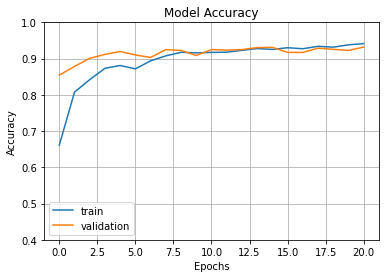

In [ ]:
fig1 = plt.gcf()
plt.plot(resnetFinalHistory.history['accuracy'])
plt.plot(resnetFinalHistory.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

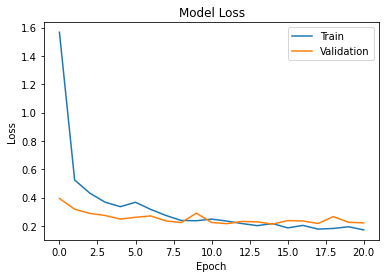

In [ ]:
plt.plot(resnetFinalHistory.history['loss'])

plt.plot(resnetFinalHistory.history['val_loss'])

plt.title('Model Loss')

plt.ylabel('Loss')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
resnetFinalPredictions = resnetFinal.predict(X_test)

In [ ]:
resnetFinalPredictionsClass = [np.argmax(x) for x in resnetFinalPredictions]

In [ ]:
accuracy_score(y_testLabeles, resnetFinalPredictionsClass)

0.9402173913043478

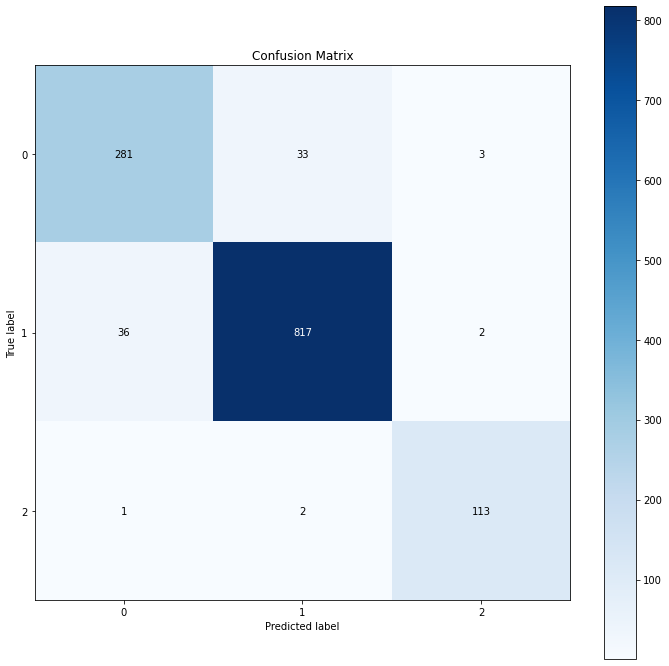

In [ ]:
actLabels = [0,1,2]
skplt.metrics.plot_confusion_matrix(

    y_testLabeles, 

    resnetFinalPredictionsClass,

    figsize=(12,12), cmap = 'Blues', labels = actLabels)

In [ ]:
print(classification_report(y_testLabeles, resnetFinalPredictionsClass))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       317
           1       0.96      0.96      0.96       855
           2       0.96      0.97      0.97       116

    accuracy                           0.94      1288
   macro avg       0.93      0.94      0.94      1288
weighted avg       0.94      0.94      0.94      1288

